<center>
    <h1>Identifying the Human Values behind Arguments</h1>
    <h1>04 - Main Model</h1>
    <h2>Natural Language Processing</h2>
    <h3>Antonio Politano, Enrico Pittini, Riccardo Spolaor and Samuele Bortolato</h3>
    <h4>antonio.politano2@studio.unibo.it, enrico.pittini@studio.unibo.it, riccardo.spolaor@studio.unibo.it, samuele.bortolato@studio.unibo.it</h4>
</center>

---

In this notebook a *Main Model* is proposed for the *Identifying the Human Values behind Arguments* task and evaluated on the provided dataset.

For more detailed informations about the used functions, look into the corresponding docstrings inside the python files, inside the `src` folder.

In [1]:
# Settings for autoreloading.

%load_ext autoreload
%autoreload 2

In [2]:
# Settings for reproducibility.

from src.utils.seeder import set_random_seed

SEED = 42
set_random_seed(SEED)

c:\Users\riccardo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download of the Dataset

In [3]:
from src.datasets.dataset_builder import get_dataframes

arguments_train_df, labels_train_df = get_dataframes('data', 'training')
arguments_test_df, labels_test_df = get_dataframes('data', 'validation')

In [4]:
TARGETS = labels_train_df.columns.to_list()

In [5]:
from src.datasets.dataset_builder import split_dataframes

(arguments_train_df, labels_train_df), (arguments_val_df, labels_val_df) = \
    split_dataframes(arguments_train_df, labels_train_df, seed=SEED)

# Model and Tokenizer Definition

In [6]:
from torch import cuda
from transformers import logging

MODEL_NAME = 'bert-base-uncased'
DEVICE = 'cuda' if cuda.is_available() else 'cpu'

# Set verbosity at "error" level
logging.set_verbosity_error()

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME, problem_type='multi_label_classification')

# Add the tokens encoding the stance to the tokenizer.
tokenizer.add_tokens(['[FAV]', '[AGN]'], special_tokens=True)

# Build a dictionary to encde the stance.
stance_encoder = {'in favor of': '[FAV]', 'against': '[AGN]'}

In [8]:
from src.models.transformer_model  import get_transformer_model

model = get_transformer_model(MODEL_NAME, num_labels=len(TARGETS),
                              tokenizer=tokenizer, device=DEVICE)

In [9]:
print('Model structure:')
print(model)

Model structure:
BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30524, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

## Training

### Create Dataloaders

In [10]:
from src.datasets.dataloader_builder import get_dataloader

BATCH_SIZE_TRAIN = 8
BATCH_SIZE_EVAL = 16

train_loader = get_dataloader(arguments_train_df, labels_train_df, tokenizer,
                             stance_encoder, batch_size=BATCH_SIZE_TRAIN,
                             shuffle=True, use_augmentation=True)
val_loader = get_dataloader(arguments_val_df, labels_val_df, tokenizer,
                             stance_encoder, batch_size=BATCH_SIZE_EVAL,
                             shuffle=False, use_augmentation=False)
test_loader = get_dataloader(arguments_test_df, labels_test_df, tokenizer,
                             stance_encoder, batch_size=BATCH_SIZE_EVAL,
                             shuffle=False, use_augmentation=False)

### Training parameters

In [11]:
import os
from torch.optim import Adam
from src.training.training_utils import Checkpoint, EarlyStopping, FocalLoss

# Set the number of epochs.
EPOCHS = 20
# Set the learning rates for the Bert model and the Classification head.
LEARNING_RATE_BERT = 1e-05
LEARNING_RATE_CLASSIFIER = 1e-03
# Set how many training steps to use for validation.
STEPS_VALIDATE = 200

# Set the loss function.
train_labels_frequencies = (labels_train_df.sum() / len(labels_train_df))
train_labels_frequencies = train_labels_frequencies.to_numpy()
loss_function = FocalLoss(alpha=train_labels_frequencies, gamma=1.5)

# Set the optimizer.
optimizer = Adam(params=[
    { 'params': model.bert.parameters(), 'lr': LEARNING_RATE_BERT },
    { 'params': model.dropout.parameters(), 'lr': LEARNING_RATE_CLASSIFIER },
    { 'params': model.classifier.parameters(), 'lr': LEARNING_RATE_CLASSIFIER }
    ])

# Set the checkpoints and the early stopping monitor.
checkpoint = Checkpoint(model, path=os.path.join('models', 'main_model.pth'))
early_stopping = EarlyStopping()

### Training

In [12]:
from src.training.training import train

# Train the model.
train_loss_history, val_loss_history, val_f1_macro_history = train(
    train_loader, val_loader, model, optimizer, loss_function, DEVICE,
    epochs=EPOCHS, steps_validate=STEPS_VALIDATE, checkpoint=checkpoint,
    early_stopping=early_stopping, reload_best_weights=True,
    use_threshold_selection=True)

epoch: 1/20, 199/540, 36s 179ms/step, loss: 0.0639               
validate: 5s, validation loss: 0.0582, validation f1 macro: 38.8 %               
epoch: 1/20, 399/540, 74s 186ms/step, loss: 0.0607               
validate: 5s, validation loss: 0.0534, validation f1 macro: 44.6 %               
epoch: 1/20, 540/540, 104s 193ms/step, loss: 0.0594               
-----------------------------------------------------------------------------------------------
epoch: 1/20, 104s, loss: 0.0594 val loss:, 0.0525, val f1 macro: 46 %
epoch: 2/20, 199/540, 33s 166ms/step, loss: 0.0526               
validate: 5s, validation loss: 0.0506, validation f1 macro: 47.8 %               
epoch: 2/20, 399/540, 71s 179ms/step, loss: 0.0522               
validate: 5s, validation loss: 0.0498, validation f1 macro: 49.4 %               
epoch: 2/20, 540/540, 100s 185ms/step, loss: 0.0522               
-----------------------------------------------------------------------------------------------
epoch: 2/20,

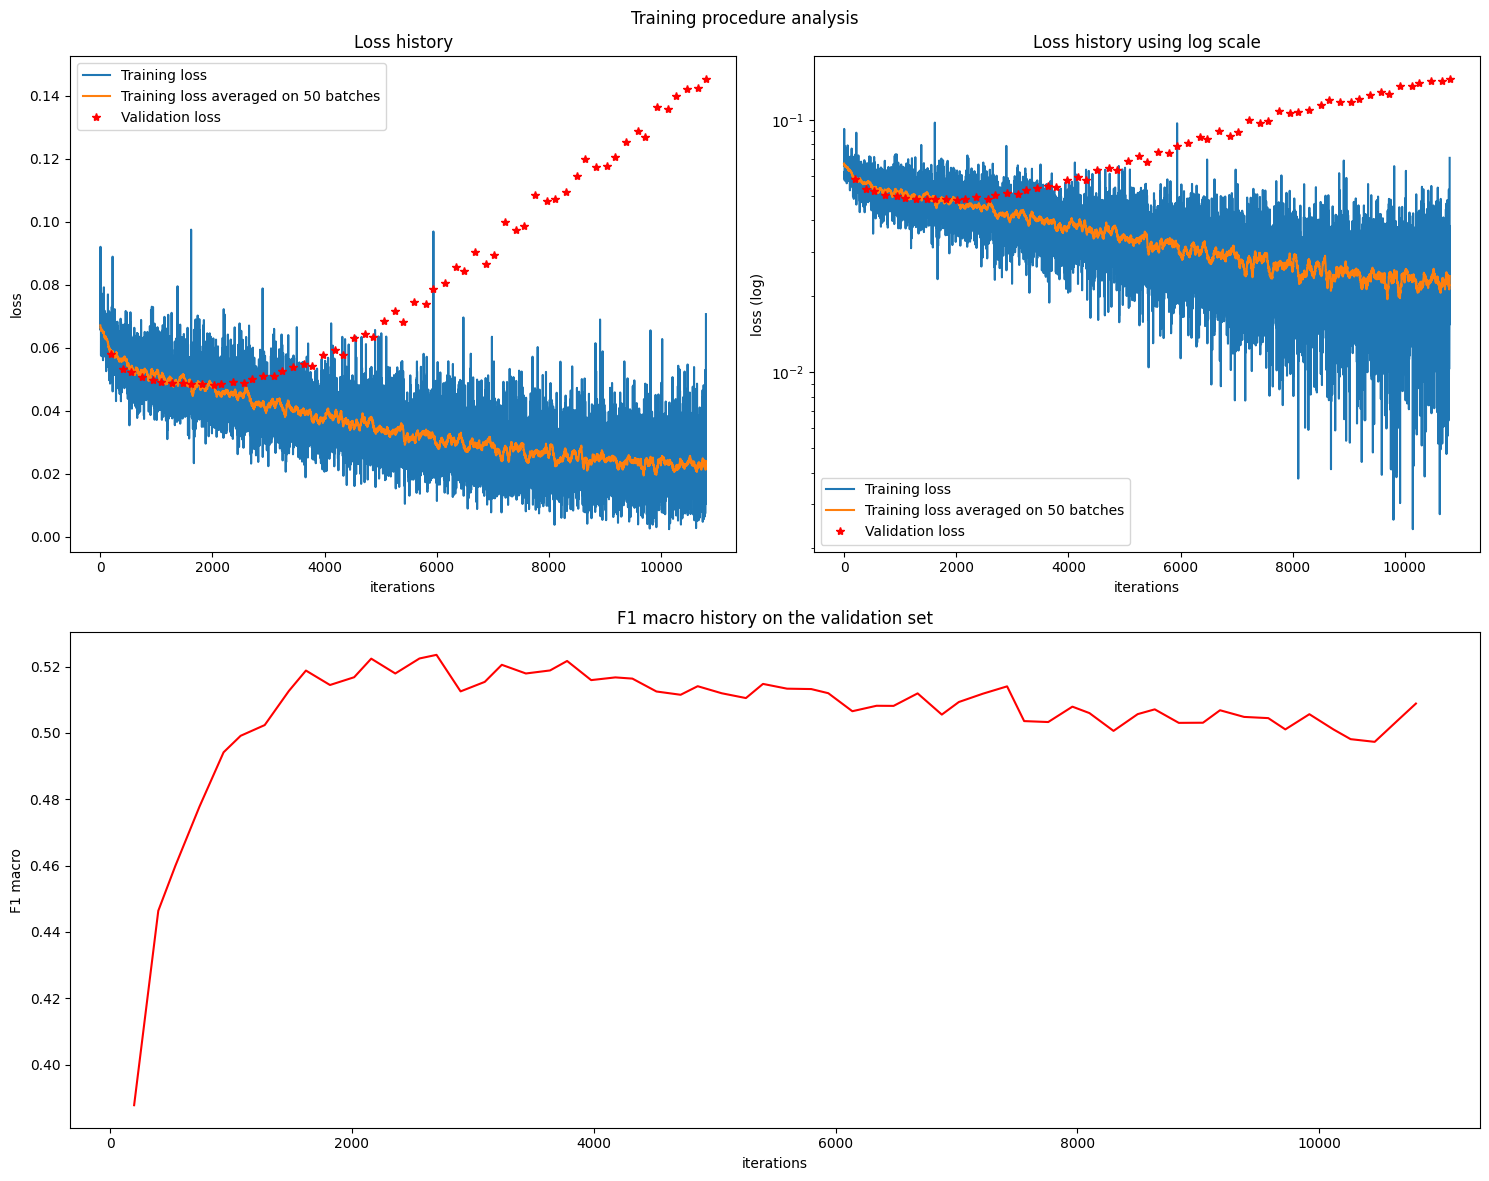

In [13]:
from src.training.training_analysis import plot_training_history

plot_training_history(train_loss_history, val_loss_history,
                      val_f1_macro_history)

In [12]:
import torch

checkpoint = torch.load('models/main_model.pth')

# Get loss history and validation loss history
model.load_state_dict(checkpoint['model_state_dict'][0])
train_loss_history = checkpoint['train_loss_history']
val_loss_history = checkpoint['val_loss_history']
val_f1_macro_history = checkpoint['val_f1_macro_history']

# Model Evaluation

## Threshold selection

In [13]:
from src.evaluation.evaluation import get_dataset_prediction_scores
import pandas as pd

# Concatenate the train and validation datasets together.
train_and_val_loader = get_dataloader(
    pd.concat([arguments_train_df, arguments_val_df], 
              ignore_index=True, sort=False),
    pd.concat([labels_train_df, labels_val_df],
              ignore_index=True, sort=False), 
    tokenizer, stance_encoder, batch_size=16, shuffle=False,
    use_augmentation=False)

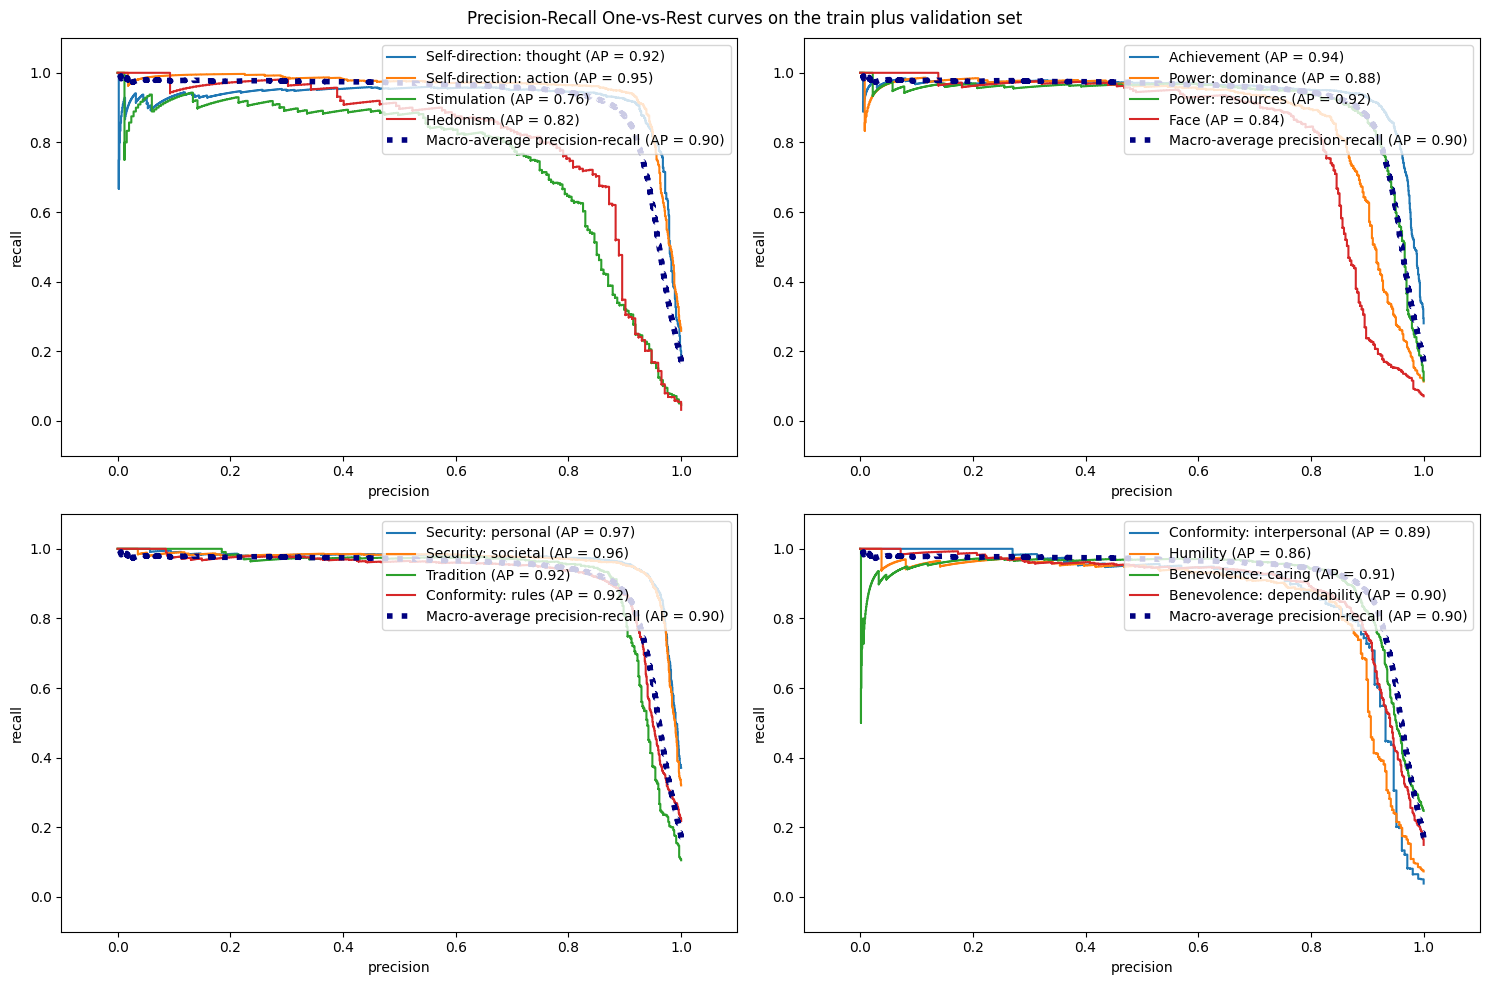

In [14]:
from src.evaluation.evaluation import get_dataset_prediction_scores
from src.evaluation.evaluation_analysis import (
    get_precision_recall_statistics, plot_precision_recall_curves)

y_scores, y_true = get_dataset_prediction_scores(model, train_and_val_loader,
                                                 DEVICE)

precision, recall, average_precision = get_precision_recall_statistics(
    y_true, y_scores, TARGETS)

plot_precision_recall_curves(precision, recall, average_precision, TARGETS,
                             'train plus validation')

In [15]:
from src.evaluation.evaluation import get_best_thresholds
import numpy as np

# Get the best thresholds.
thresholds_per_target = get_best_thresholds(y_true, y_scores)

# Save the best thresholds.
np.save(os.path.join('models', 'main_model_thresholds.npy'),
        thresholds_per_target)

for target, thresh in zip(TARGETS, thresholds_per_target):
    print(f'"{target}" best threshold: {thresh:.4f}')

"Self-direction: thought" best threshold: 0.6742
"Self-direction: action" best threshold: 0.9545
"Stimulation" best threshold: 1.0416
"Hedonism" best threshold: 1.5570
"Achievement" best threshold: 0.3461
"Power: dominance" best threshold: 2.0404
"Power: resources" best threshold: 1.4983
"Face" best threshold: 0.5967
"Security: personal" best threshold: 0.2220
"Security: societal" best threshold: 0.4989
"Tradition" best threshold: 0.6344
"Conformity: rules" best threshold: 0.1958
"Conformity: interpersonal" best threshold: 1.3840
"Humility" best threshold: 1.0890
"Benevolence: caring" best threshold: 0.9191
"Benevolence: dependability" best threshold: 0.8617
"Universalism: concern" best threshold: -0.0818
"Universalism: nature" best threshold: 1.1195
"Universalism: tolerance" best threshold: 0.5798
"Universalism: objectivity" best threshold: 0.5898


In [16]:
import torch
from src.evaluation.evaluation import get_dataset_prediction_scores

In [17]:
preds, y_true = get_dataset_prediction_scores(model, train_and_val_loader, DEVICE)

preds = torch.tensor(preds)
y_true = torch.tensor(y_true)

# Argsort elements by non decreasing values of each column (prediction of a specific target)
idx = torch.argsort(preds, 0)

# Sort predictions and true labels based on argsort
s_preds = torch.gather(preds, 0, idx)
s_true = torch.gather(y_true, 0, idx)

In [18]:
# Cumulative sum of total positive and negative instances

c_positive = torch.cumsum(s_true, 0)
c_negative = torch.cumsum(1 - s_true, 0)

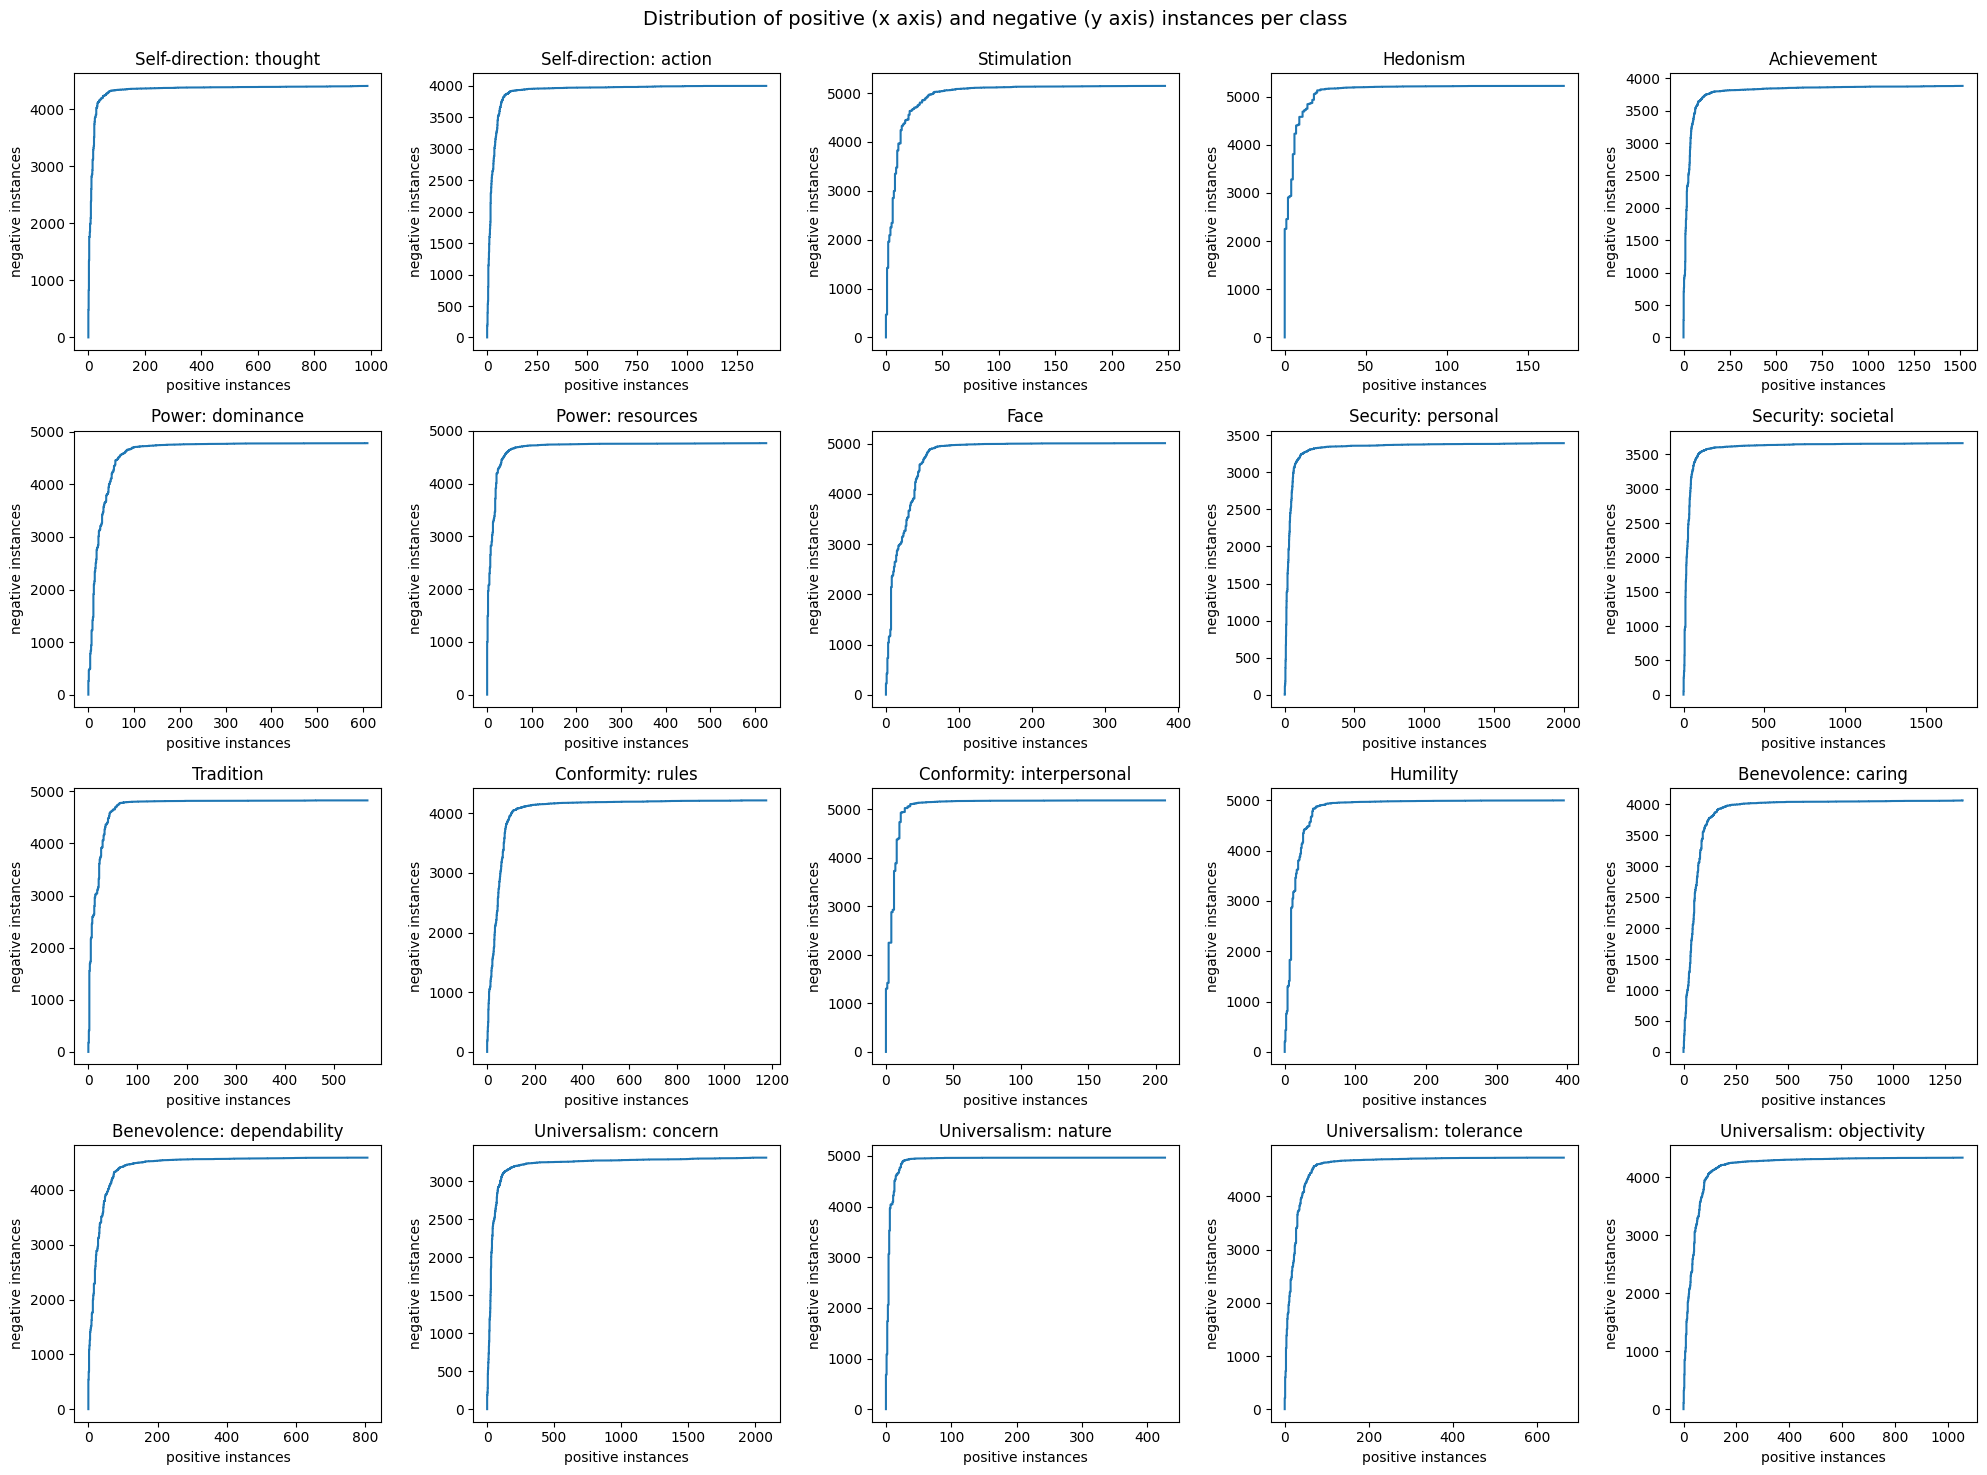

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
plt.suptitle('Distribution of positive (x axis) and negative (y axis) instances per class\n', size=14)
for i, l in enumerate(TARGETS):
    ax = plt.subplot(4, 5 , i + 1)
    ax.set_title(l)
    ax.set_xlabel('positive instances')
    ax.set_ylabel('negative instances')
    ax.plot(c_positive[:,i], c_negative[:,i])
plt.tight_layout()
plt.show()

In [20]:
# Cumulative sum of true positive elements for each class at 
c_true_positive = c_positive[-1:] - c_positive

R = (torch.arange(len(c_true_positive)) + 1)[:, None]
c_precision = c_true_positive / (R[-1] - R + 1) + 1e-7
c_recall = c_true_positive / (c_true_positive[:1] + 1e-7) + 1e-7
c_F1 = 2 * (c_precision * c_recall) / (c_precision + c_recall)

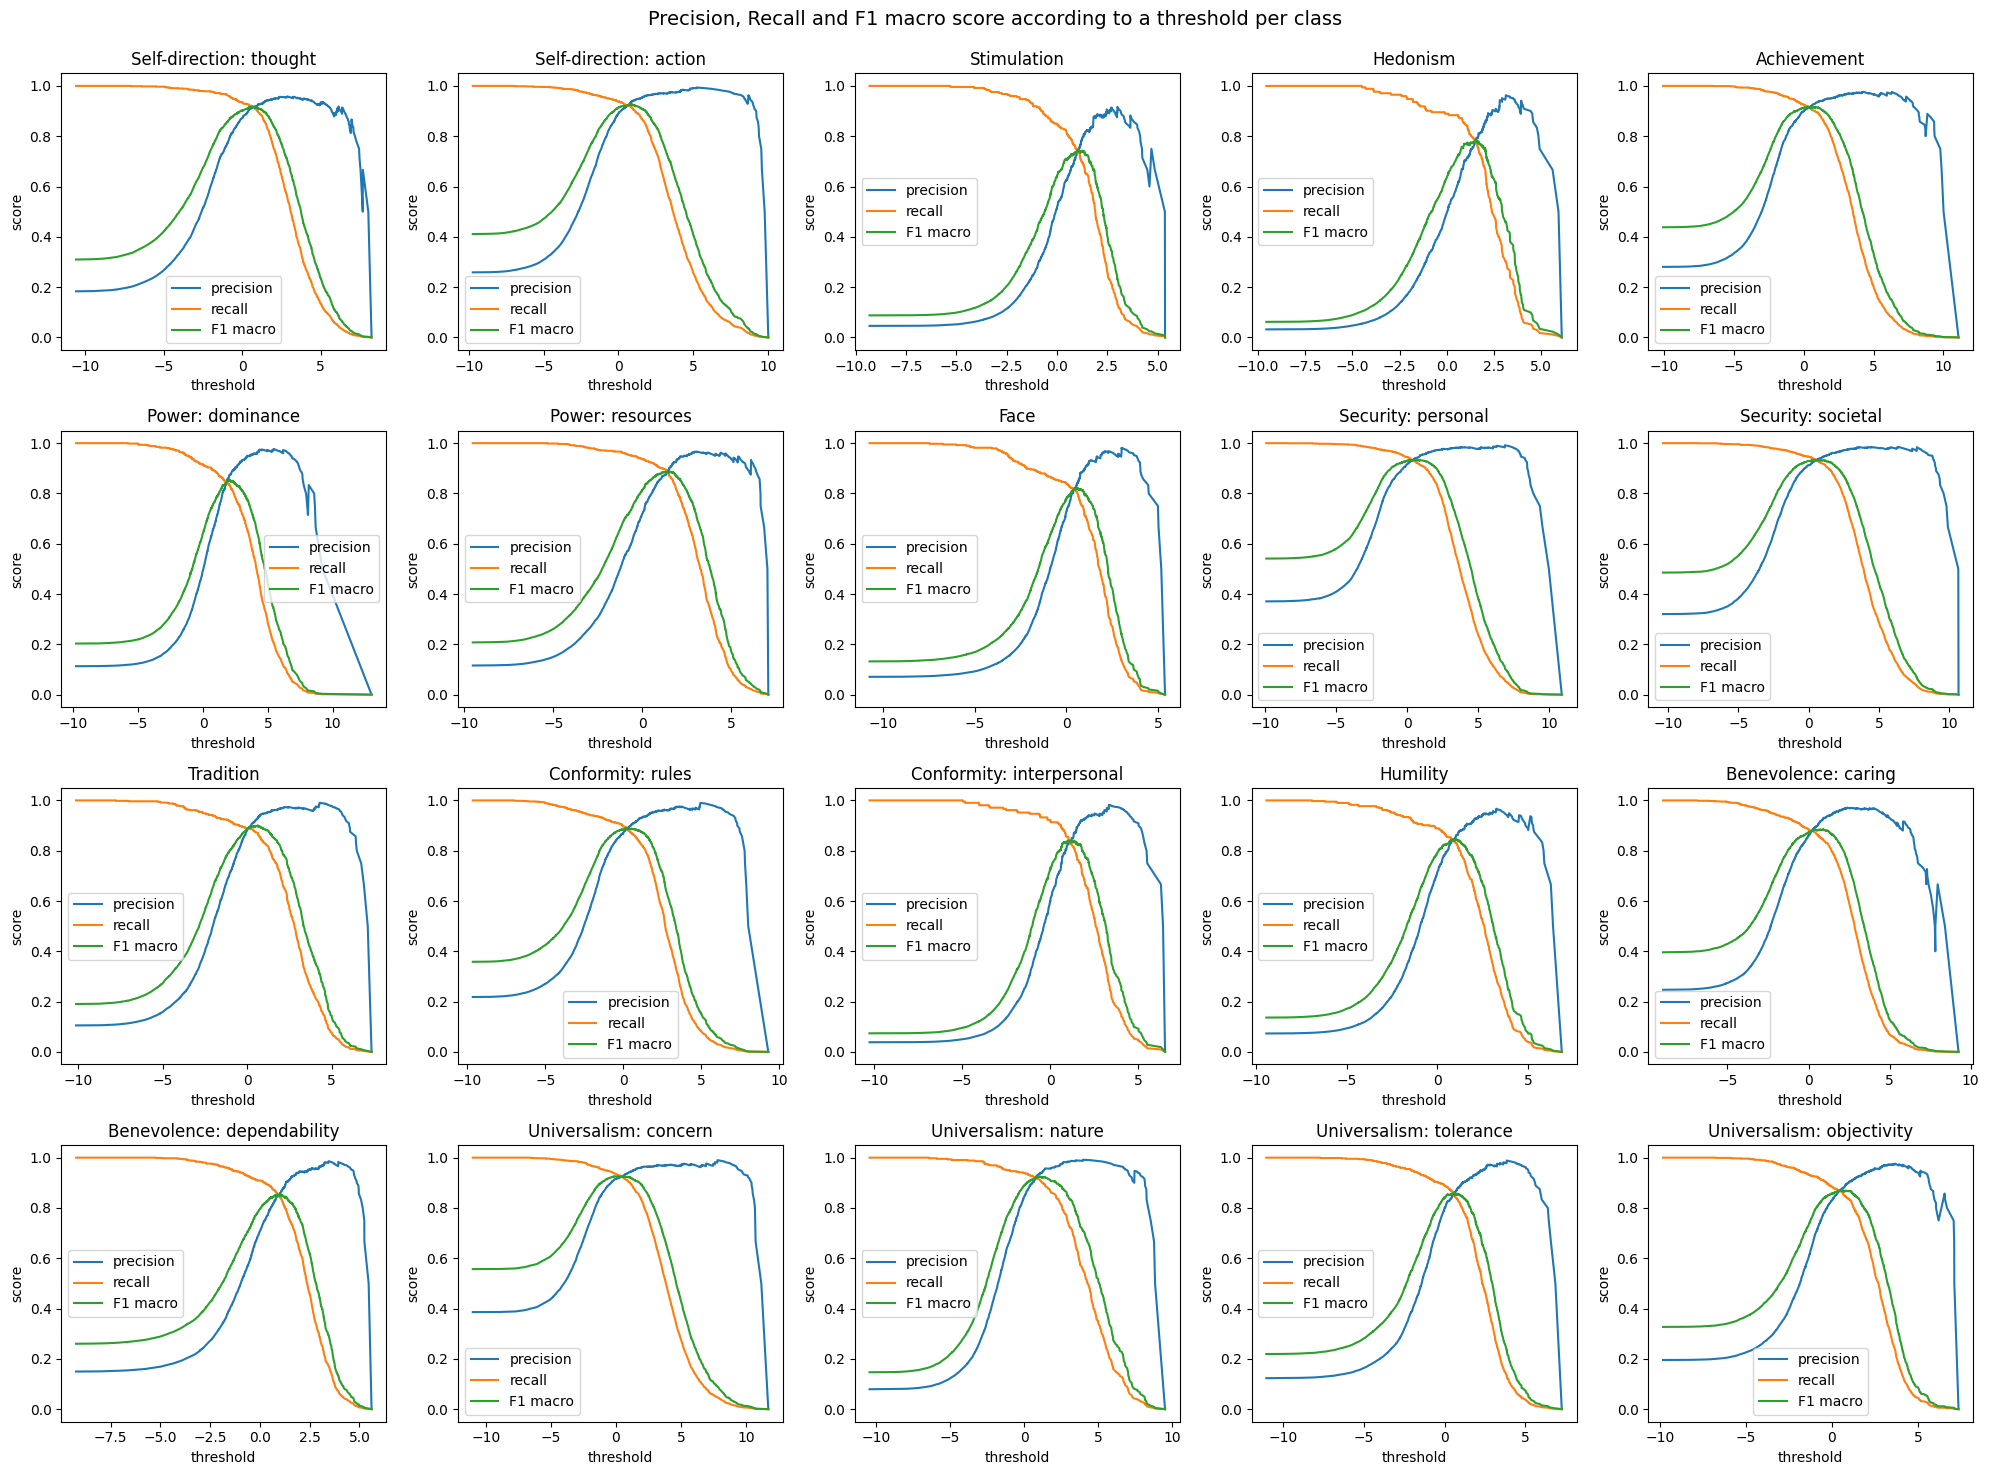

In [21]:
plt.figure(figsize=(20, 15))
plt.suptitle('Precision, Recall and F1 macro score according to a threshold per class\n', size=14)
for i, l in enumerate(TARGETS):
    ax = plt.subplot(4, 5, i + 1)
    ax.set_title(l)
    # TODO: Use sigmoid for threshold or not?
    ax.plot(s_preds[:,i], c_precision[:,i], label='precision')
    ax.plot(s_preds[:,i], c_recall[:,i], label='recall')
    ax.plot(s_preds[:,i], c_F1[:,i], label='F1 macro')
    ax.set_xlabel('threshold')
    ax.set_ylabel('score')
    #ax.set_xlim(0, 1)
    ax.legend()
plt.tight_layout()
plt.show()

In [22]:
import numpy as np

# Get the index of maximum F1 macro score for each target
idx_max = c_F1.argmax(0)
# Get the threshold for each target
thresholds_per_target = np.array([s_preds[idx, i] for i, idx in enumerate(idx_max)])

## Evaluation on the Validation set

In [23]:
from sklearn.metrics import f1_score
from src.evaluation.evaluation import get_dataset_predictions

y_pred, y_true = get_dataset_predictions(model, val_loader, DEVICE)

# Compute Validation F1 macro score.
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

print('Validation f1-score macro on the validation set with base threshold 0:', 
      f'{f1_macro:.3f}')

Validation f1-score macro on the validation set with base threshold 0: 0.489


In [24]:
from sklearn.metrics import f1_score
from src.evaluation.evaluation import get_dataset_predictions

y_pred, y_true = get_dataset_predictions(model, val_loader, DEVICE,
                                         thresholds_per_target)

# Compute Validation F1 macro score with threshold selection.
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

print('Validation f1-score macro on the validation set with threshold',
      f'selection: {f1_macro:.3f}')

Validation f1-score macro on the validation set with threshold selection: 0.479


In [25]:
from src.evaluation.evaluation_analysis import print_classification_report

print_classification_report(y_true, y_pred, TARGETS, 'validation')

Classification report for the validation set:
                            precision    recall  f1-score   support

   Self-direction: thought       0.64      0.64      0.64       184
    Self-direction: action       0.68      0.61      0.64       261
               Stimulation       0.17      0.12      0.14        51
                  Hedonism       0.30      0.20      0.24        35
               Achievement       0.60      0.61      0.61       300
          Power: dominance       0.48      0.36      0.41       128
          Power: resources       0.57      0.46      0.51       129
                      Face       0.29      0.15      0.20        78
        Security: personal       0.71      0.73      0.72       406
        Security: societal       0.71      0.70      0.70       345
                 Tradition       0.68      0.42      0.52       114
         Conformity: rules       0.53      0.52      0.52       249
 Conformity: interpersonal       0.45      0.40      0.42        35
 

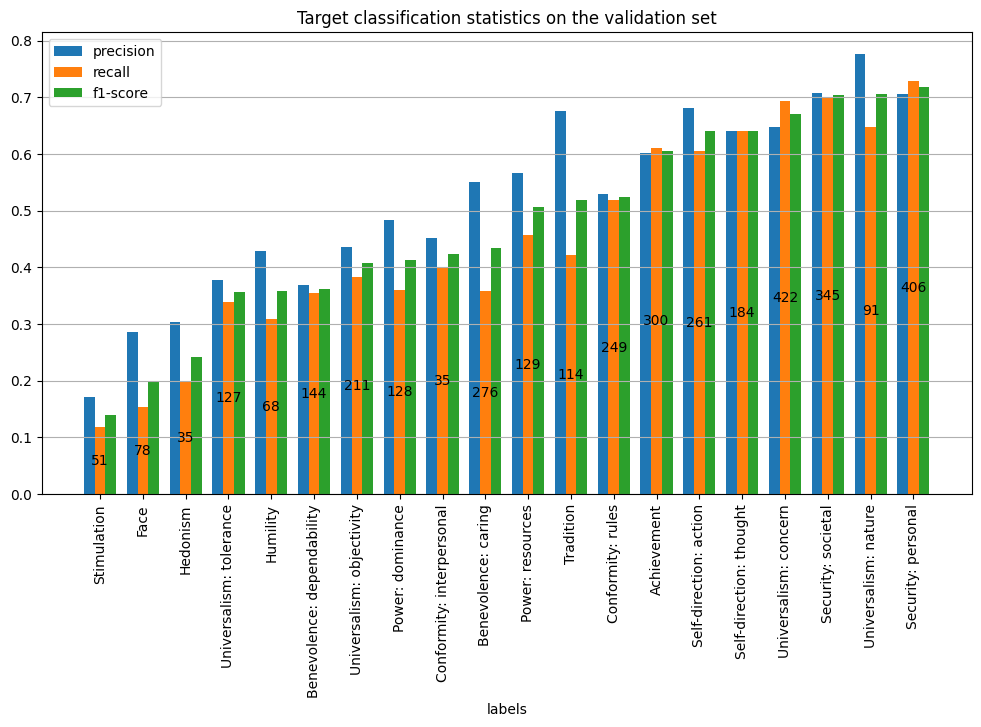

In [26]:
from src.evaluation.evaluation_analysis import \
    plot_targets_classification_statistics

plot_targets_classification_statistics(y_true, y_pred, TARGETS, 'validation')

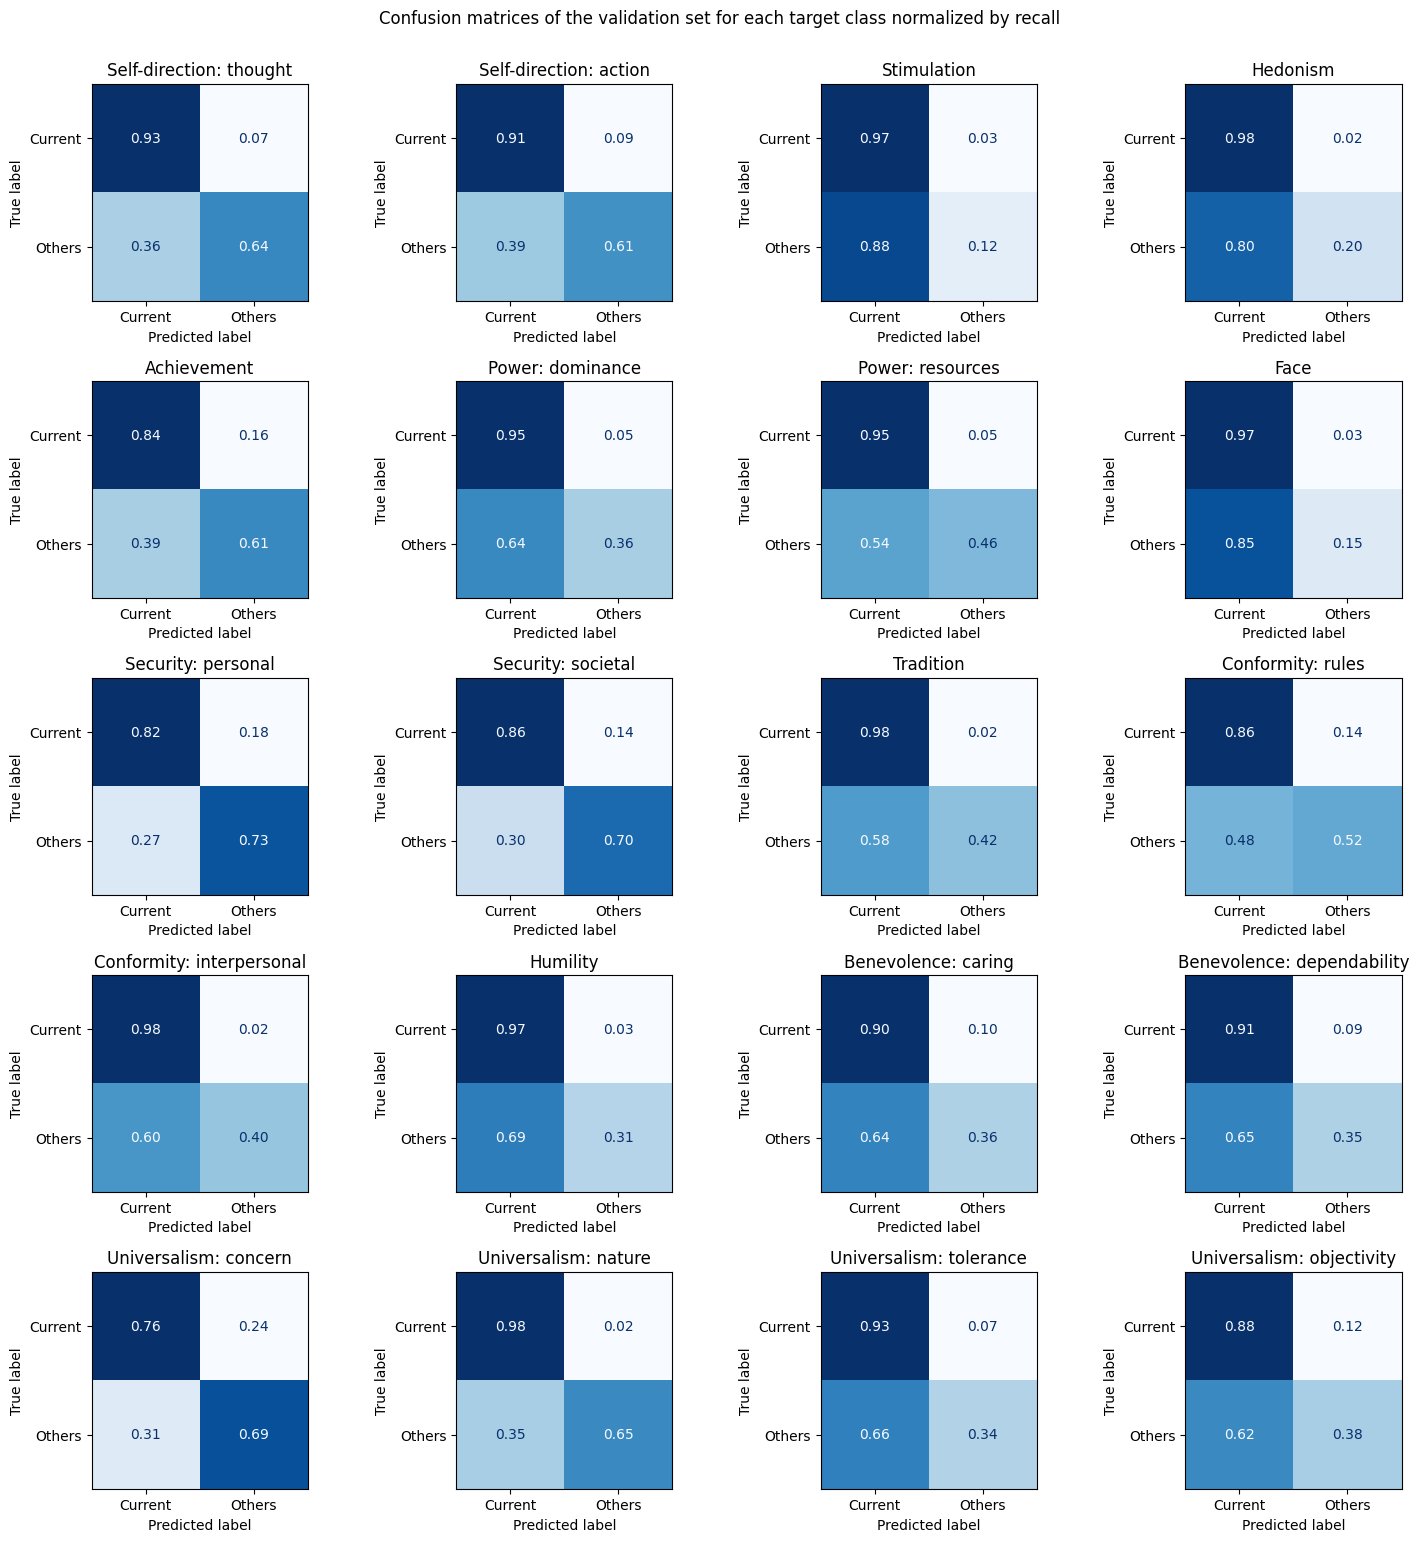

In [27]:
from src.evaluation.evaluation_analysis import plot_confusion_matrices

plot_confusion_matrices(y_true, y_pred, TARGETS, 'validation',
                        normalize_by='recall')

## Evaluation on the Test set

In [28]:
from sklearn.metrics import f1_score
from src.evaluation.evaluation import get_dataset_predictions

y_pred, y_true = get_dataset_predictions(model, test_loader, DEVICE)

# Compute Test F1 macro score.
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

print('Validation f1-score macro on the test set with base threshold 0:',
      f'{f1_macro:.3f}')

Validation f1-score macro on the test set with base threshold 0: 0.437


In [29]:
from sklearn.metrics import f1_score
from src.evaluation.evaluation import get_dataset_predictions

y_pred, y_true = get_dataset_predictions(model, test_loader, DEVICE,
                                         thresholds_per_target)

# Compute Test F1 macro score with threshold selection.
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

print('Validation f1-score macro on the test set with threshold selection:',
      f'{f1_macro:.3f}')

Validation f1-score macro on the test set with threshold selection: 0.411


In [30]:
from src.evaluation.evaluation_analysis import print_classification_report

print_classification_report(y_true, y_pred, TARGETS, 'test')

Classification report for the test set:
                            precision    recall  f1-score   support

   Self-direction: thought       0.51      0.43      0.47       251
    Self-direction: action       0.57      0.52      0.54       496
               Stimulation       0.46      0.08      0.14       138
                  Hedonism       0.50      0.23      0.32       103
               Achievement       0.64      0.62      0.63       575
          Power: dominance       0.27      0.16      0.20       164
          Power: resources       0.44      0.33      0.37       132
                      Face       0.27      0.07      0.11       130
        Security: personal       0.69      0.76      0.72       759
        Security: societal       0.61      0.65      0.63       488
                 Tradition       0.56      0.34      0.42       172
         Conformity: rules       0.52      0.42      0.46       455
 Conformity: interpersonal       0.47      0.25      0.33        60
       

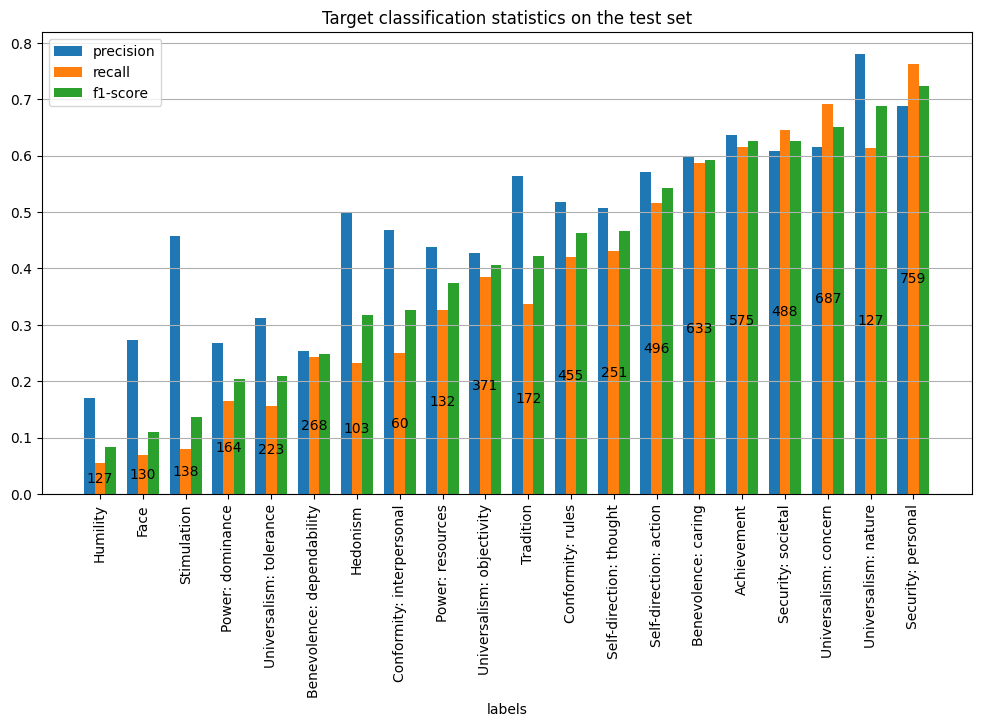

In [31]:
from src.evaluation.evaluation_analysis import \
    plot_targets_classification_statistics

plot_targets_classification_statistics(y_true, y_pred, TARGETS, 'test')

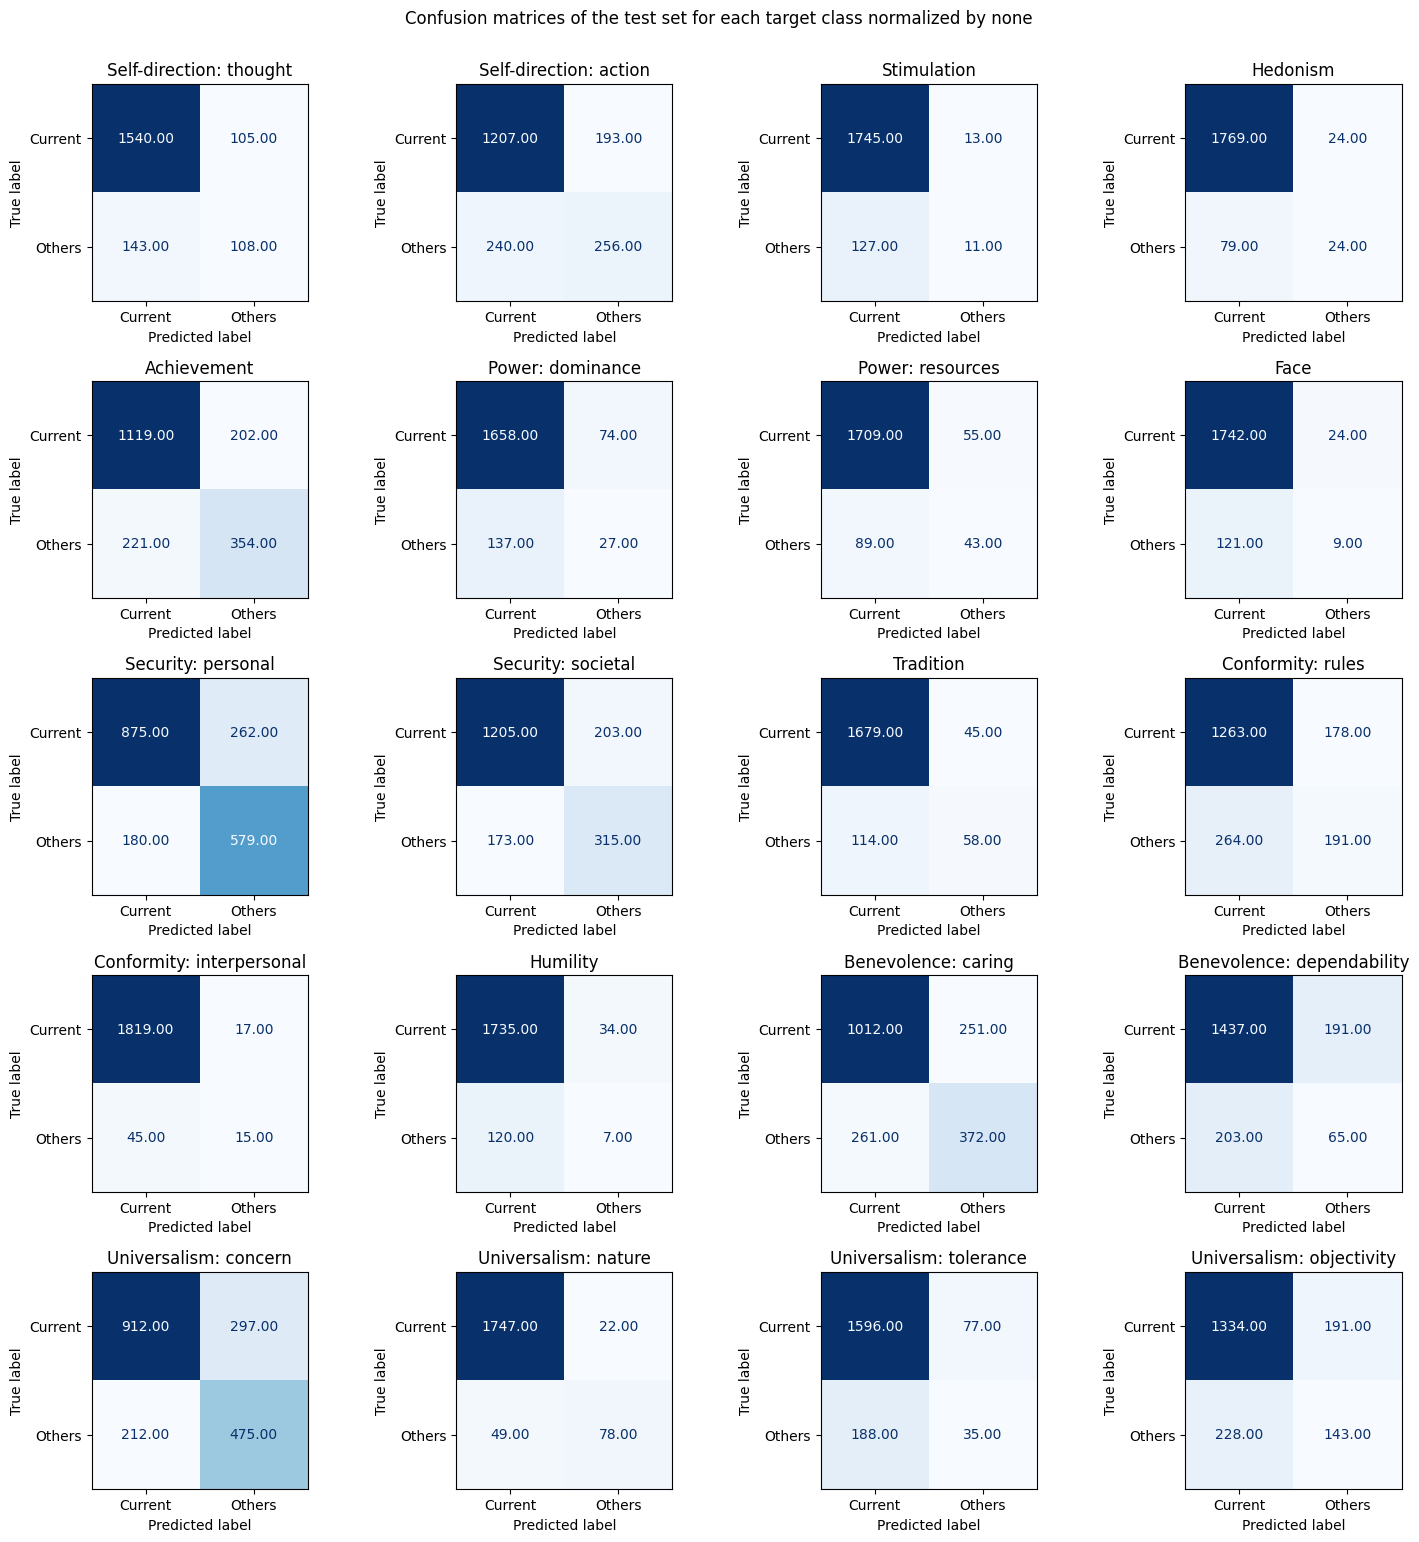

In [32]:
from src.evaluation.evaluation_analysis import plot_confusion_matrices

plot_confusion_matrices(y_true, y_pred, TARGETS, 'test')

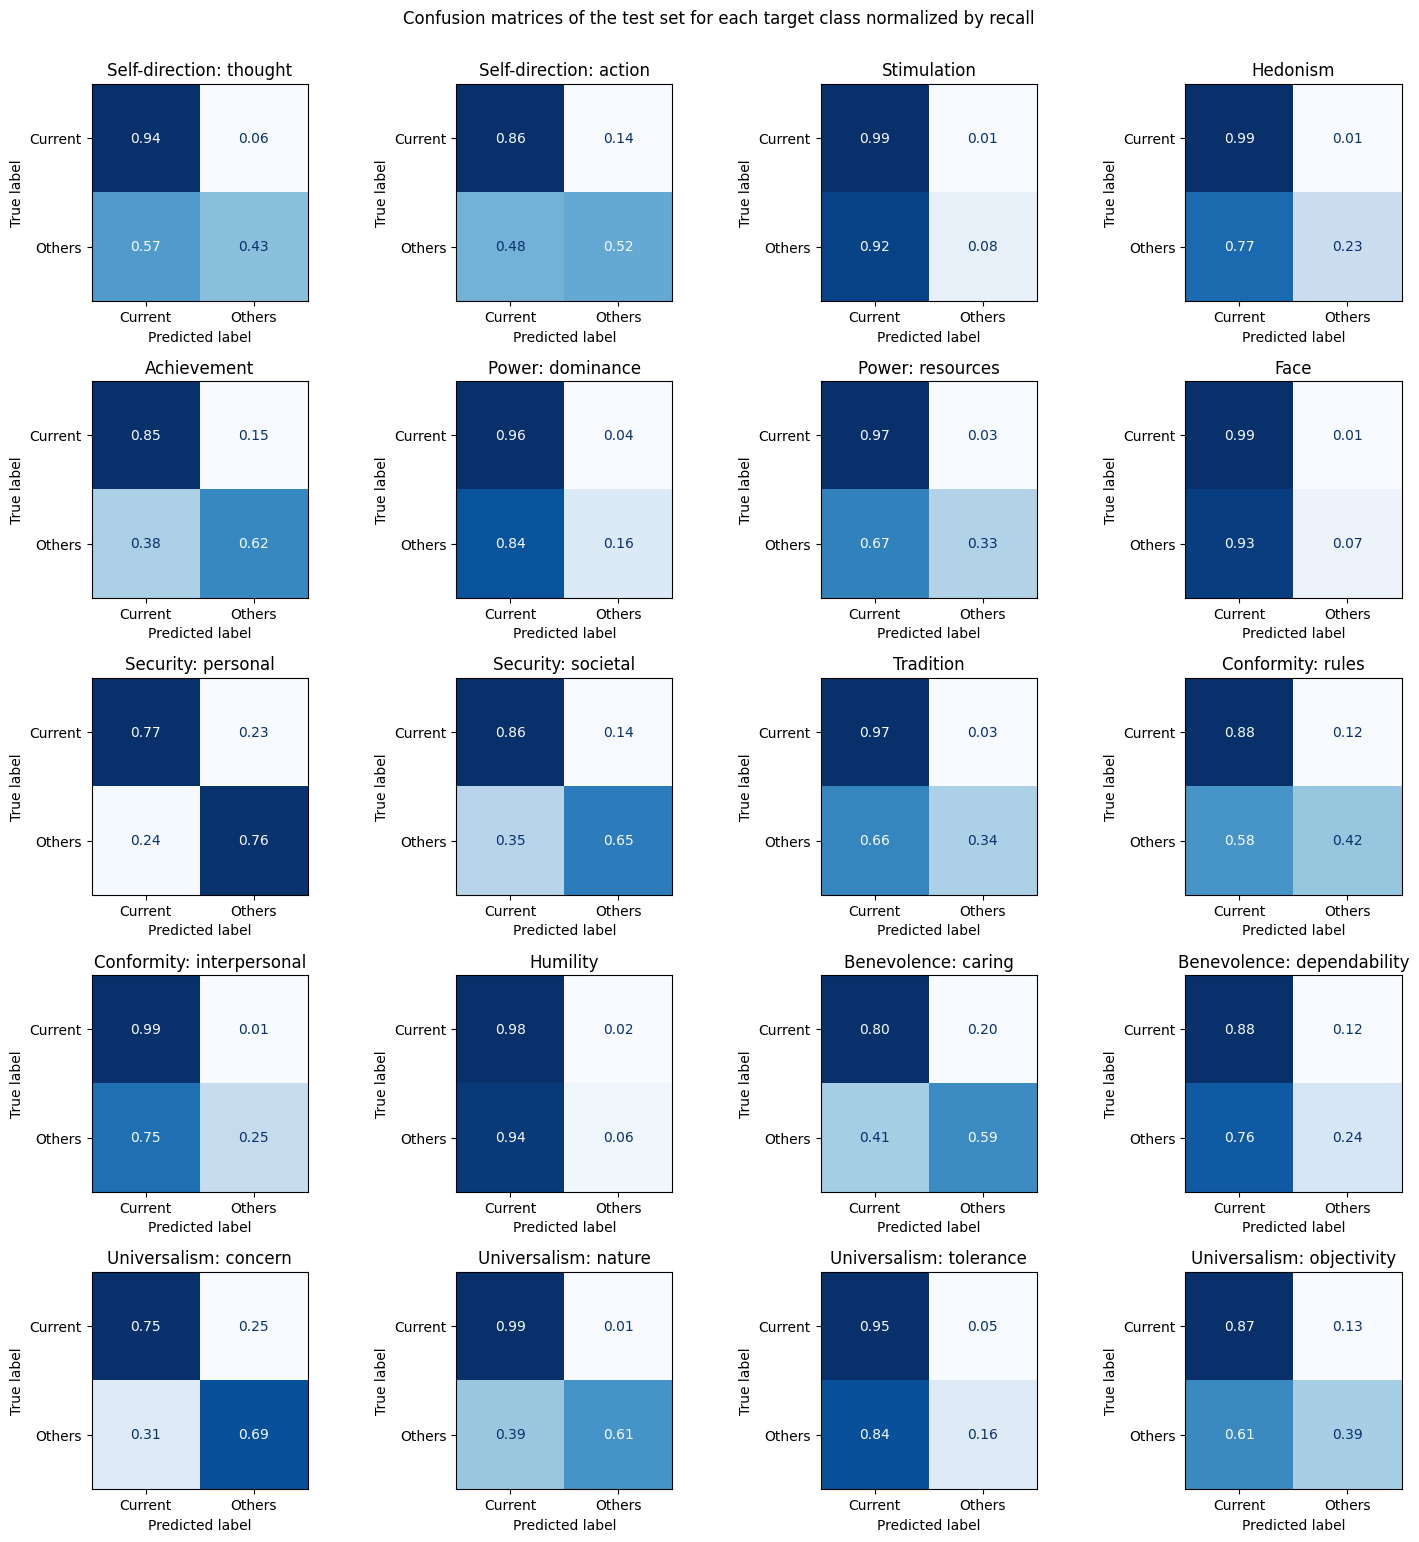

In [33]:
from src.evaluation.evaluation_analysis import plot_confusion_matrices

plot_confusion_matrices(y_true, y_pred, TARGETS, 'test', normalize_by='recall')